Dependencies

In [50]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


Dataset

In [2]:
df=pd.read_csv('houseprice.csv',usecols=["SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea",
                                         "Street", "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF"]).dropna()

In [3]:
df.shape

(1201, 10)

In [4]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,YearBuilt,1stFlrSF,2ndFlrSF,SalePrice
0,60,RL,65.0,8450,Pave,Reg,2003,856,854,208500
1,20,RL,80.0,9600,Pave,Reg,1976,1262,0,181500
2,60,RL,68.0,11250,Pave,IR1,2001,920,866,223500
3,70,RL,60.0,9550,Pave,IR1,1915,961,756,140000
4,60,RL,84.0,14260,Pave,IR1,2000,1145,1053,250000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1201 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1201 non-null   int64  
 1   MSZoning     1201 non-null   object 
 2   LotFrontage  1201 non-null   float64
 3   LotArea      1201 non-null   int64  
 4   Street       1201 non-null   object 
 5   LotShape     1201 non-null   object 
 6   YearBuilt    1201 non-null   int64  
 7   1stFlrSF     1201 non-null   int64  
 8   2ndFlrSF     1201 non-null   int64  
 9   SalePrice    1201 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 103.2+ KB


In [6]:
for i in df.columns:
    print("Column name {} and unique values are {}".format(i,len(df[i].unique())))


Column name MSSubClass and unique values are 15
Column name MSZoning and unique values are 5
Column name LotFrontage and unique values are 110
Column name LotArea and unique values are 869
Column name Street and unique values are 2
Column name LotShape and unique values are 4
Column name YearBuilt and unique values are 112
Column name 1stFlrSF and unique values are 678
Column name 2ndFlrSF and unique values are 368
Column name SalePrice and unique values are 597


In [7]:
datetime.datetime.now().year

2025

In [8]:
df['Total Years']=datetime.datetime.now().year-df['YearBuilt']

In [9]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'SalePrice',
       'Total Years'],
      dtype='object')

In [10]:
#Creating categorical features
cat_features=["MSSubClass", "MSZoning", "Street", "LotShape"]
out_feature="SalePrice"

In [11]:
df["MSSubClass"].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  80, 160,  75, 180,
        40,  85])

LabelEncoder helps to map each unique category to a distinct integer, enabling the model to process these categorical features effectively.

In [12]:
from sklearn.preprocessing import LabelEncoder
lbl_encoders={}
for feature in cat_features:
    lbl_encoders[feature]=LabelEncoder()
    df[feature]=lbl_encoders[feature].fit_transform(df[feature])


In [13]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,YearBuilt,1stFlrSF,2ndFlrSF,SalePrice,Total Years
0,5,3,65.0,8450,1,3,2003,856,854,208500,22
1,0,3,80.0,9600,1,3,1976,1262,0,181500,49
2,5,3,68.0,11250,1,0,2001,920,866,223500,24
3,6,3,60.0,9550,1,0,1915,961,756,140000,110
4,5,3,84.0,14260,1,0,2000,1145,1053,250000,25
...,...,...,...,...,...,...,...,...,...,...,...
1455,5,3,62.0,7917,1,3,1999,953,694,175000,26
1456,0,3,85.0,13175,1,3,1978,2073,0,210000,47
1457,6,3,66.0,9042,1,3,1941,1188,1152,266500,84
1458,0,3,68.0,9717,1,3,1950,1078,0,142125,75


After label encoding, we convert all categorical features to NumPy arrays and then to tensors, which are subsequently used as inputs for embedding layers.

In [14]:
### # Combine the selected categorical features into a 2D NumPy array, where each row represents a record, 
# and each column corresponds to one of the selected features.
cat_features=np.stack([df['MSSubClass'],df['MSZoning'],df['Street'],df['LotShape']],1)
cat_features

array([[5, 3, 1, 3],
       [0, 3, 1, 3],
       [5, 3, 1, 0],
       ...,
       [6, 3, 1, 3],
       [0, 3, 1, 3],
       [0, 3, 1, 3]], shape=(1201, 4))

In [15]:
import torch
cat_features=torch.tensor(cat_features,dtype=torch.int64)
cat_features


tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        ...,
        [6, 3, 1, 3],
        [0, 3, 1, 3],
        [0, 3, 1, 3]])

In [16]:
# take continuous variable
cont_features=[]
for i in df.columns:
    if i in ["MSSubClass", "MSZoning", "Street", "LotShape","SalePrice"]:
        pass
    else:
        cont_features.append(i)


In [17]:
cont_features

['LotFrontage', 'LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'Total Years']

In [18]:
# Stacking continuous variable to a tensor
cont_values=np.stack([df[i].values for i in cont_features],axis=1)
cont_values=torch.tensor(cont_values,dtype=torch.float) 
cont_values


tensor([[   65.,  8450.,  2003.,   856.,   854.,    22.],
        [   80.,  9600.,  1976.,  1262.,     0.,    49.],
        [   68., 11250.,  2001.,   920.,   866.,    24.],
        ...,
        [   66.,  9042.,  1941.,  1188.,  1152.,    84.],
        [   68.,  9717.,  1950.,  1078.,     0.,    75.],
        [   75.,  9937.,  1965.,  1256.,     0.,    60.]])

In [19]:
cont_values.dtype

torch.float32

In [20]:
# Dependent Feature 
# Convert the 'SalePrice' column to a PyTorch tensor and reshape it into a 2D tensor
# with one column (shape: [n_samples, 1]) to be compatible with machine learning models.
y=torch.tensor(df['SalePrice'].values,dtype=torch.float).reshape(-1,1)
y


tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [21]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1201 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1201 non-null   int64  
 1   MSZoning     1201 non-null   int64  
 2   LotFrontage  1201 non-null   float64
 3   LotArea      1201 non-null   int64  
 4   Street       1201 non-null   int64  
 5   LotShape     1201 non-null   int64  
 6   YearBuilt    1201 non-null   int64  
 7   1stFlrSF     1201 non-null   int64  
 8   2ndFlrSF     1201 non-null   int64  
 9   SalePrice    1201 non-null   int64  
 10  Total Years  1201 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 112.6 KB


In [22]:
cat_features.shape,cont_values.shape,y.shape


(torch.Size([1201, 4]), torch.Size([1201, 6]), torch.Size([1201, 1]))

Embeddings for categorical features

In [23]:
# Embedding Size For Categorical columns 
# The embedding size for categorical columns: is important because it determines the number of inputs that should be passed to the embedding layers
cat_dims=[len(df[col].unique()) for col in ["MSSubClass", "MSZoning", "Street", "LotShape"]]
cat_dims

[15, 5, 2, 4]

In [24]:
#Output dimension should be set based on the input dimension (min(50,feature dimension//2))
embedding_dim= [(x, min(50, (x + 1) // 2)) for x in cat_dims]


In [25]:
embedding_dim

[(15, 8), (5, 3), (2, 1), (4, 2)]

In [26]:
# Creates a list of embedding layers, one for each (input size, output size) pair in embedding_dim.
embed_representation=nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
embed_representation


ModuleList(
  (0): Embedding(15, 8)
  (1): Embedding(5, 3)
  (2): Embedding(2, 1)
  (3): Embedding(4, 2)
)

In [27]:
#This ModuleList contains 4 embedding layers, each corresponding to a different categorical feature.
#For each embedding layer, the first number represents the size of the vocabulary (the number of unique categories),
# and the second number represents the embedding dimension (the number of dimensions for the embedding vector).

In [28]:
cat_features


tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        ...,
        [6, 3, 1, 3],
        [0, 3, 1, 3],
        [0, 3, 1, 3]])

In [29]:
cat_features4=cat_features[:4]
cat_features4


tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        [6, 3, 1, 0]])

In [30]:
pd.set_option('display.max_rows', 500)
embedding_val=[]
for i,e in enumerate(embed_representation):
    embedding_val.append(e(cat_features[:,i]))


In [31]:
embedding_val

[tensor([[-0.7959, -0.1882,  0.3682,  ...,  1.2356,  0.5884, -1.4428],
         [ 1.4184,  1.4489,  0.4345,  ..., -0.3900, -0.1232, -1.2650],
         [-0.7959, -0.1882,  0.3682,  ...,  1.2356,  0.5884, -1.4428],
         ...,
         [-1.4404,  0.4848,  0.6923,  ...,  0.0759,  0.4336,  1.0282],
         [ 1.4184,  1.4489,  0.4345,  ..., -0.3900, -0.1232, -1.2650],
         [ 1.4184,  1.4489,  0.4345,  ..., -0.3900, -0.1232, -1.2650]],
        grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.9145,  2.0021, -0.5080],
         [ 0.9145,  2.0021, -0.5080],
         [ 0.9145,  2.0021, -0.5080],
         ...,
         [ 0.9145,  2.0021, -0.5080],
         [ 0.9145,  2.0021, -0.5080],
         [ 0.9145,  2.0021, -0.5080]], grad_fn=<EmbeddingBackward0>),
 tensor([[0.3850],
         [0.3850],
         [0.3850],
         ...,
         [0.3850],
         [0.3850],
         [0.3850]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.4823, -0.3792],
         [ 1.4823, -0.3792],
         [ 0.1111, -0.5346],

In [32]:
z = torch.cat(embedding_val, 1)
z
#combines the tensors from embedding_val along the columns (dimension 1) into a single tensor z,
# where all the embeddings are merged together into a unified representation.

tensor([[-0.7959, -0.1882,  0.3682,  ...,  0.3850,  1.4823, -0.3792],
        [ 1.4184,  1.4489,  0.4345,  ...,  0.3850,  1.4823, -0.3792],
        [-0.7959, -0.1882,  0.3682,  ...,  0.3850,  0.1111, -0.5346],
        ...,
        [-1.4404,  0.4848,  0.6923,  ...,  0.3850,  1.4823, -0.3792],
        [ 1.4184,  1.4489,  0.4345,  ...,  0.3850,  1.4823, -0.3792],
        [ 1.4184,  1.4489,  0.4345,  ...,  0.3850,  1.4823, -0.3792]],
       grad_fn=<CatBackward0>)

In [33]:
# Implement dropupout
droput=nn.Dropout(.4)
#creates a dropout layer that will randomly set 40% of the input units to zero during training,
# helping to prevent overfitting by regularizing the model.

In [34]:
final_embed=droput(z)
final_embed


tensor([[-0.0000, -0.3137,  0.6137,  ...,  0.6417,  0.0000, -0.0000],
        [ 2.3640,  2.4148,  0.7242,  ...,  0.6417,  0.0000, -0.6320],
        [-1.3266, -0.3137,  0.6137,  ...,  0.0000,  0.1852, -0.8910],
        ...,
        [-2.4006,  0.8080,  1.1538,  ...,  0.6417,  2.4705, -0.6320],
        [ 2.3640,  0.0000,  0.7242,  ...,  0.6417,  2.4705, -0.6320],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.6320]],
       grad_fn=<MulBackward0>)

In [35]:
class FeedForwardNN(nn.Module):
    # Initialize the feedforward neural network model, each class should have 2 functions: __init__ and forward

    def __init__(self, embedding_dim, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        # Step 1: Define the embedding layers for categorical features
        self.embeds = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
        # Step 2: Dropout layer for regularization applied after embedding
        self.emb_drop = nn.Dropout(p)
        # Step 3: Batch normalization for continuous features
        # Normalize continuous features for better model performance
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Step 4: Create the fully connected layers (hidden layers) in the model
        # 'layers' is a list containing the number of neurons for each hidden layer.
        # 'n_emb' is the total number of features after embeddings are concatenated.
        # 'n_in' is the number of input features for the first layer, which is the sum of embeddings and continuous features.

        layerlist = []
        n_emb = sum((out for inp,out in embedding_dim))
        n_in = n_emb + n_cont
        
        for i in layers:
            # For each layer in 'layers', create a fully connected (Linear) layer followed by:
            # 1. ReLU activation for non-linearity
            # 2. Batch normalization to stabilize training
            # 3. Dropout to prevent overfitting

            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        # Step 5: Final output layer to make the predictions
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [39]:
torch.manual_seed(100)
model=FeedForwardNN(embedding_dim,len(cont_features),1,[100,50],p=0.4)


In [40]:
model

FeedForwardNN(
  (embeds): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [43]:
model.parameters

<bound method Module.parameters of FeedForwardNN(
  (embeds): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)>

Define Loss And Optimizer

In [41]:
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [44]:
df.shape

(1201, 11)

In [45]:
cont_values.shape

torch.Size([1201, 6])

In [46]:
batch_size=1200
test_size=int(batch_size*0.15)
train_categorical=cat_features[:batch_size-test_size]
test_categorical=cat_features[batch_size-test_size:batch_size]
train_cont=cont_values[:batch_size-test_size]
test_cont=cont_values[batch_size-test_size:batch_size]
y_train=y[:batch_size-test_size]
y_test=y[batch_size-test_size:batch_size]

In [47]:
len(train_categorical),len(test_categorical),len(train_cont),len(test_cont),len(y_train),len(y_test)

(1020, 180, 1020, 180, 1020, 180)

In [48]:
epochs=5000
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred=model(train_categorical,train_cont)
    loss=torch.sqrt(loss_function(y_pred,y_train)) ### RMSE
    final_losses.append(loss)
    if i%10==1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch number: 1 and the loss : 200496.859375
Epoch number: 11 and the loss : 200493.8125
Epoch number: 21 and the loss : 200489.609375
Epoch number: 31 and the loss : 200483.046875
Epoch number: 41 and the loss : 200474.359375
Epoch number: 51 and the loss : 200462.390625
Epoch number: 61 and the loss : 200448.109375
Epoch number: 71 and the loss : 200429.328125
Epoch number: 81 and the loss : 200408.890625
Epoch number: 91 and the loss : 200384.375
Epoch number: 101 and the loss : 200358.328125
Epoch number: 111 and the loss : 200324.53125
Epoch number: 121 and the loss : 200290.8125
Epoch number: 131 and the loss : 200253.25
Epoch number: 141 and the loss : 200208.875
Epoch number: 151 and the loss : 200162.6875
Epoch number: 161 and the loss : 200112.625
Epoch number: 171 and the loss : 200060.234375
Epoch number: 181 and the loss : 199998.140625
Epoch number: 191 and the loss : 199938.28125
Epoch number: 201 and the loss : 199889.171875
Epoch number: 211 and the loss : 199812.95312

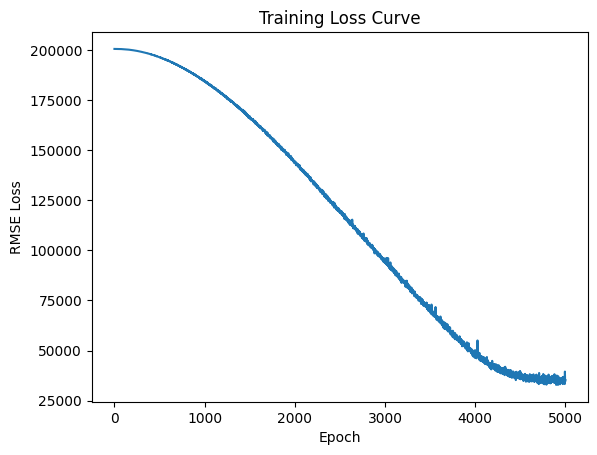

In [53]:
%matplotlib inline
# Detach the tensors in final_losses, convert them to NumPy, and then plot
final_losses_numpy = [loss.detach().numpy() for loss in final_losses]
plt.plot(range(epochs), final_losses_numpy)
plt.ylabel('RMSE Loss')
plt.xlabel('Epoch')
plt.title('Training Loss Curve')
plt.show()


In [55]:
#Validate the Test Data
y_pred=""
with torch.no_grad():
    y_pred=model(test_categorical,test_cont)
    loss=torch.sqrt(loss_function(y_pred,y_test))
print('RMSE: {}'.format(loss))


RMSE: 42756.9921875


In [56]:
data_verify=pd.DataFrame(y_test.tolist(),columns=["Test"])


In [57]:
data_predicted=pd.DataFrame(y_pred.tolist(),columns=["Prediction"])


In [58]:
final_output=pd.concat([data_verify,data_predicted],axis=1)
final_output['Difference']=final_output['Test']-final_output['Prediction']
final_output.head()


,Test,Prediction,Difference
0,130000.0,233482.984375,-103482.984375
1,138887.0,141734.890625,-2847.890625
2,175500.0,147861.484375,27638.515625
3,195000.0,228324.140625,-33324.140625
4,142500.0,156589.406250,-14089.406250


In [59]:
torch.save(model,'HousePrice.pt')

In [60]:
torch.save(model.state_dict(),'HouseWeights.pt')

In [65]:
embs_size=[(15, 8), (5, 3), (2, 1), (4, 2)]
model1=FeedForwardNN(embs_size,6,1,[100,50],p=0.4)
model1.load_state_dict(torch.load('HouseWeights.pt'))

C:\Users\pc\AppData\Local\Temp\ipykernel_17952\4225596820.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('HouseWeights.pt'))


<All keys matched successfully>

In [66]:
model1.eval()

FeedForwardNN(
  (embeds): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)